### Dependencies

In [1]:
import os, sys
import pathlib, pickle
import argparse
import numpy as np
import numpy.random as npr
import tensorflow as tf
import scipy.stats as sps
import matplotlib.pyplot as plt

from timeit import default_timer
from pdb import set_trace as bp

In [2]:
# Ensure dictionaries are ordered
from sys import version_info
if (version_info.major + 0.1 * version_info.minor < 3.6):
    from collections import OrderedDict as dict

In [3]:
# Relative import
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import tasks as Tasks
from src.models import gaussian_process

In [4]:
# Setup logging
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    format='%(asctime)-4s %(levelname)s:%(name)s:%(message)s')

### Notebook settings

In [5]:
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
plt.rc('figure', dpi=256)
np.set_printoptions(precision=3)

### TensorFlow backend

In [6]:
def jitter_diagonal(tensor, jitter=None, name='jittered_tensor', rank=None, dtype=None):
    if (rank is None): rank = len(tensor.get_shape().as_list())
    if (dtype is None): dtype = tensor.dtype
    if (jitter is None): jitter = 1e-6 if tf.as_dtype(dtype)==tf.float64 else 1e-4
    assert rank >= 2, 'Input tensor must be at least 2D'
    with tf.name_scope('jitter_diagonal') as scope:
        tensor_shape = tf.shape(tensor)
        test_square = tf.assert_equal(tensor_shape[-1], 
                                      tensor_shape[-2],
                                      name='test_square')
        with tf.control_dependencies([test_square]):
            jittered_eye = jitter * tf.eye(tensor_shape[-1], dtype=dtype)

        for k in range(rank - 2):
            jittered_eye = tf.expand_dims(jittered_eye, axis=0)

        return tf.add(tensor, jittered_eye, name=name)
    
    
def jitter_cholesky(tensor, jitter=None, name='jittered_chol', **kwargs):
    '''
    Cholesky factorization of >=2-dimensional square tensor 'tensor',
    stabilized via additition of a small, positive constant to
    the input's diagonal.
    '''
    with tf.name_scope('jitter_cholesky') as scope:
        jittered_tensor = jitter_diagonal(tensor, jitter=jitter, **kwargs)
        return tf.cholesky(jittered_tensor, name=name)

In [7]:
def sample_posteriors(Means, Covs, proj=None, Chols=None):
    '''
    Arguments:
        Means - Tensor of shape [N, q, 1] containing the posterior
                means of N distinct size q inputs pools.
        Covs - Tensor of shape [N, q, q] containing the posterior
                covariance of N distinct size q inputs pools.
    Returns:
        samples - Tensor of shape [N, M, q] containing M samples 
                    from each of N distinct size q input pools.   
    '''
    with tf.name_scope('sample_posteriors') as scope:
        if (Chols is None): 
            Chols = jitter_cholesky(Covs)

        if (proj is None):
            pool_size = Chols.get_shape()[-1].value
            proj = tf.random_normal([2**10, pool_size]) #[!] temp hack

        # Sample residuals from posterior
        Residuals = tf.einsum('ijk,lk->ilj', Chols, proj)

        # Add in means to form sample values    
        return tf.transpose(Means, [0, 2, 1]) + Residuals

In [8]:
def negative_ei(samples, levels):
    '''
    Monte Carlo estimate to negative EI.
    '''
    minima = tf.reduce_min(samples, axis=-1)
    improvements = tf.nn.relu(levels - minima)
    estimates = tf.reduce_mean(improvements, axis=-1)
    return tf.negative(estimates)

In [9]:
def optimize_loss(sess, task, loss_fn, model, inputs_old, outputs_old,
    pools_var, num_steps=10**3, batch_size=64, noise=None, dtype=None, 
    scope='optimize_loss', reuse=None, eval_freq=None, rng=None, **kwargs):
    if (rng is None): rng = npr
    if (dtype is None): dtype = pools_var.dtype
    if (eval_freq is None): eval_freq = num_steps//10
    with tf.variable_scope(scope, reuse=reuse) as vs:  
        # Detect shape info
        pool_size = pools_var.get_shape()[-2].value
        num_prev = len(inputs_old)
        
        # Define graph input nodes
        inputs_old_ref = tf.placeholder(dtype, [num_prev, task.input_dim], name='inputs/old')
        outputs_old_ref = tf.placeholder(dtype, [num_prev, 1], name='outputs/old')
        precis_ref = tf.placeholder(dtype, [num_prev, num_prev], name='precis')
        proj_ref = tf.placeholder(dtype, [None, pool_size], name='proj')

        # Create predictive posterior op
        Means, Covs = model.predict(pools_var, inputs_old_ref, outputs_old_ref, full_cov=True)
        
        # Build Monte Carlo estimates to acquisition functions
        samples = sample_posteriors(Means, Covs, proj=proj_ref)
        levels = tf.reduce_min(outputs_old_ref)
        losses_op = loss_fn(samples, levels)
        loss_op = tf.reduce_mean(losses_op)

        # Initialize optimizer and build update_op(s)
        optimizer = tf.train.AdamOptimizer()
        _update_op = optimizer.minimize(loss_op, var_list=[pools_var])
        with tf.control_dependencies([_update_op]):
            update_op = tf.assign(pools_var, tf.clip_by_value(pools_var, 0, 1))

        # Pre-compute and cache precision matrix
        feed_dict =\
        {
            inputs_old_ref : inputs_old,
            outputs_old_ref : outputs_old,
        }

        # Prepare for SGD
        local_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
        sess.run(tf.variables_initializer(local_vars)) 
        test_proj = rng.randn(2**14, pool_size)
        
        # Perform SGD
        trace = dict(pools=dict(), losses=dict())
        for step in range(num_steps):            
            if (step % eval_freq == 0): 
                # Estimate ground truth using a consistent set of projections
                trace['pools'][step], trace['losses'][step] = sess.run\
                (
                    [pools_var, losses_op],
                    {**feed_dict, proj_ref:test_proj}
                )
                logger.info('Estimated losses at t={:d}: N({:.2e}, {:.2e})'\
                            .format(step, 
                                    np.mean(trace['losses'][step]), 
                                    np.std(trace['losses'][step]))
                           )

            # Evaluate MC integral using new minibatch of projections
            minibatch = rng.randn(batch_size, pool_size)
            _ = sess.run(update_op, {**feed_dict, proj_ref:minibatch})
        
        # Compute final estimates (post-optimization)
        pools, losses = sess.run([pools_var, losses_op], {**feed_dict, proj_ref:test_proj})
        
        # Return pool w/ smallest loss (i.e. largest acquisition)
        argmin = np.argmin(losses)
        loss = losses[argmin]
        pool = sess.run(pools_var[argmin])
        logger.info('Final estimated loss at t={:d}: {:.2e}'.format(step, loss))
        return pool, loss, trace

In [10]:
def get_episodes(sess, task, num_episodes, episode_len, inputs=None,
    input_ref=None, rng=None, **kwargs):
    '''
    Get some i/o sequences.
    '''
    if (rng is None): rng = npr
    if (inputs is None):
        shape = [num_episodes, episode_len, task.input_dim]
        inputs = rng.rand(*shape)

    outputs, initial_state = [], None
    for k, inputs_k in enumerate(inputs):
        if hasattr(task, 'active_state'):
            initial_state = task.active_state
            task.active_state = k

        if hasattr(task, 'numpy'):
            outputs_k = task.numpy(inputs_k, **kwargs)
        else:
            if (input_ref is None): input_ref = tf.placeholder(task.dtype)
            outputs_k = sess.run(task.tensorflow(input_ref), {input_ref:inputs_k})
        outputs.append(outputs_k)

        if (initial_state is not None): task.active_state = initial_state

    return (inputs, np.stack(outputs))

### Initialization

In [11]:
# Run configuration
seed = npr.randint(0, 2**31-1)
logger.info('pRNG seed: {:d}'.format(seed))

dtype = 'float64'
input_dim = 1
num_episodes = 1

# Initialize run
sess = tf.InteractiveSession()
tf.set_random_seed(seed)

# Create black-box task
task = getattr(Tasks, 'univariate05')(input_dim, noise=1e-3, dtype=dtype)

# Create surrogate model
model = gaussian_process(name='gp', dtype=dtype)
params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='gp')
sess.run(tf.variables_initializer(params))

2018-11-27 14:19:08 INFO:__main__:pRNG seed: 1798171778


In [12]:
# Create <tf.Variable> for sets of inputs (pools) and associated ops
num_starts = 32 #num. starts for multi-start SGD
parallelism = 2 #num. inputs per pool

var_shape = [num_starts, parallelism, task.input_dim]
pools_var = tf.get_variable('pools', shape=var_shape, dtype=dtype, 
                        initializer=tf.random_uniform_initializer)

pool_init_op = tf.variables_initializer([pools_var])

first_pass = True

### Run optimizer

In [13]:
# Reset pRNG seeds for better repeatability
rng = npr.RandomState(seed + 1)
tf.set_random_seed(seed + 1)

# Generate initial episodes (i.e. sequence of I/O pairs)
episodes = get_episodes(sess, task, num_episodes=1, episode_len=3, rng=rng)

# For each initial episode, optimize pools
for episode_enum, (inputs_old, outputs_old) in enumerate(zip(*episodes)):
    sess.run(pool_init_op) #reset starting values for pools
    model.fit(sess, inputs_old, outputs_old) #fit model to initial i/o sequence
    inputs_new, loss, trace = optimize_loss(sess, task, negative_ei, model,
                                       inputs_old, outputs_old, pools_var, 
                                       rng=rng, reuse=not first_pass)

first_pass = False #reuse optimization variables in future runs

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5.759694
  Number of iterations: 88
  Number of functions evaluations: 222


2018-11-27 14:19:09 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5.759694
  Number of iterations: 88
  Number of functions evaluations: 222
2018-11-27 14:19:09 INFO:__main__:Estimated losses at t=0: N(-2.55e-02, 5.22e-03)
2018-11-27 14:19:10 INFO:__main__:Estimated losses at t=100: N(-3.06e-02, 8.29e-03)
2018-11-27 14:19:10 INFO:__main__:Estimated losses at t=200: N(-3.29e-02, 1.04e-02)
2018-11-27 14:19:10 INFO:__main__:Estimated losses at t=300: N(-3.36e-02, 1.08e-02)
2018-11-27 14:19:10 INFO:__main__:Estimated losses at t=400: N(-3.36e-02, 1.08e-02)
2018-11-27 14:19:11 INFO:__main__:Estimated losses at t=500: N(-3.36e-02, 1.08e-02)
2018-11-27 14:19:11 INFO:__main__:Estimated losses at t=600: N(-3.36e-02, 1.08e-02)
2018-11-27 14:19:11 INFO:__main__:Estimated losses at t=700: N(-3.43e-02, 1.13e-02)
2018-11-27 14:19:11 INFO:__main__:Estimated losses at t=800: N(-3.43e-02, 1.12e-02)
2018-11-27 14

### Visualization

In [14]:
def plot_posterior(sess, task, model, inputs_old, outputs_old, inputs_new=None, minima=None, dtype=None):
    if (dtype is None): dtype = task.dtype
    assert task.input_dim == 1,\
        'Plotting not yet implemented for tasks with dimensionality > 1'
 
    # Define TensorFlow backend
    inputs_new_ref = tf.placeholder(dtype, shape=[None, task.input_dim])
    inputs_old_ref = tf.placeholder(dtype, shape=[None, task.input_dim])
    outputs_old_ref = tf.placeholder(dtype, shape=[None, 1])

    eval_op = task.tensorflow(inputs_new_ref)
    mu_op, sigma2_op = model.predict(inputs_new_ref, inputs_old_ref, outputs_old_ref)
    
    # Plot response surface
    fig = plt.figure(figsize=[12, 8])    
    ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)

    x_1d = np.linspace(0, 1, 256)
    x_2d = x_1d[:, None]
    y_2d = sess.run(eval_op, {inputs_new_ref : x_2d})
    y_1d = y_2d[:, 0]
    
    feed_dict =\
    {
        inputs_new_ref : x_2d,
        inputs_old_ref : inputs_old,
        outputs_old_ref : outputs_old,
    }
    mu, sigma2 = map(lambda x: np.squeeze(x, -1), sess.run([mu_op, sigma2_op], feed_dict))
    sigma = np.sqrt(sigma2)
        
    ax.plot(x_1d, y_1d, '--k', linewidth=1.5, alpha=0.8, zorder=2)
    ax.fill_between(x_1d, mu + sigma, mu - sigma, alpha=0.2, zorder=1,
                    color='steelblue')
    ax.plot(x_1d, mu, 'steelblue', linewidth=1.5, alpha=0.9, zorder=3)

    ax.scatter(inputs_old, outputs_old, marker='.', s=128, edgecolor='k',
                c='tab:orange',  alpha=0.8, linewidth=0.5, zorder=4)
    
    if (inputs_new is not None):
        mu_new = sess.run(mu_op, {**feed_dict, inputs_new_ref:inputs_new})
        ax.scatter(inputs_new, mu_new, marker='X', s=64, edgecolor='k', 
                   c='tab:green', alpha=0.8, linewidth=0.5, zorder=4)

    if (minima is not None):
        ax.scatter(*minima, marker='*', s=128, edgecolor='k',
                    c='goldenrod', alpha=0.8, linewidth=0.5, zorder=5)
    
    return ax

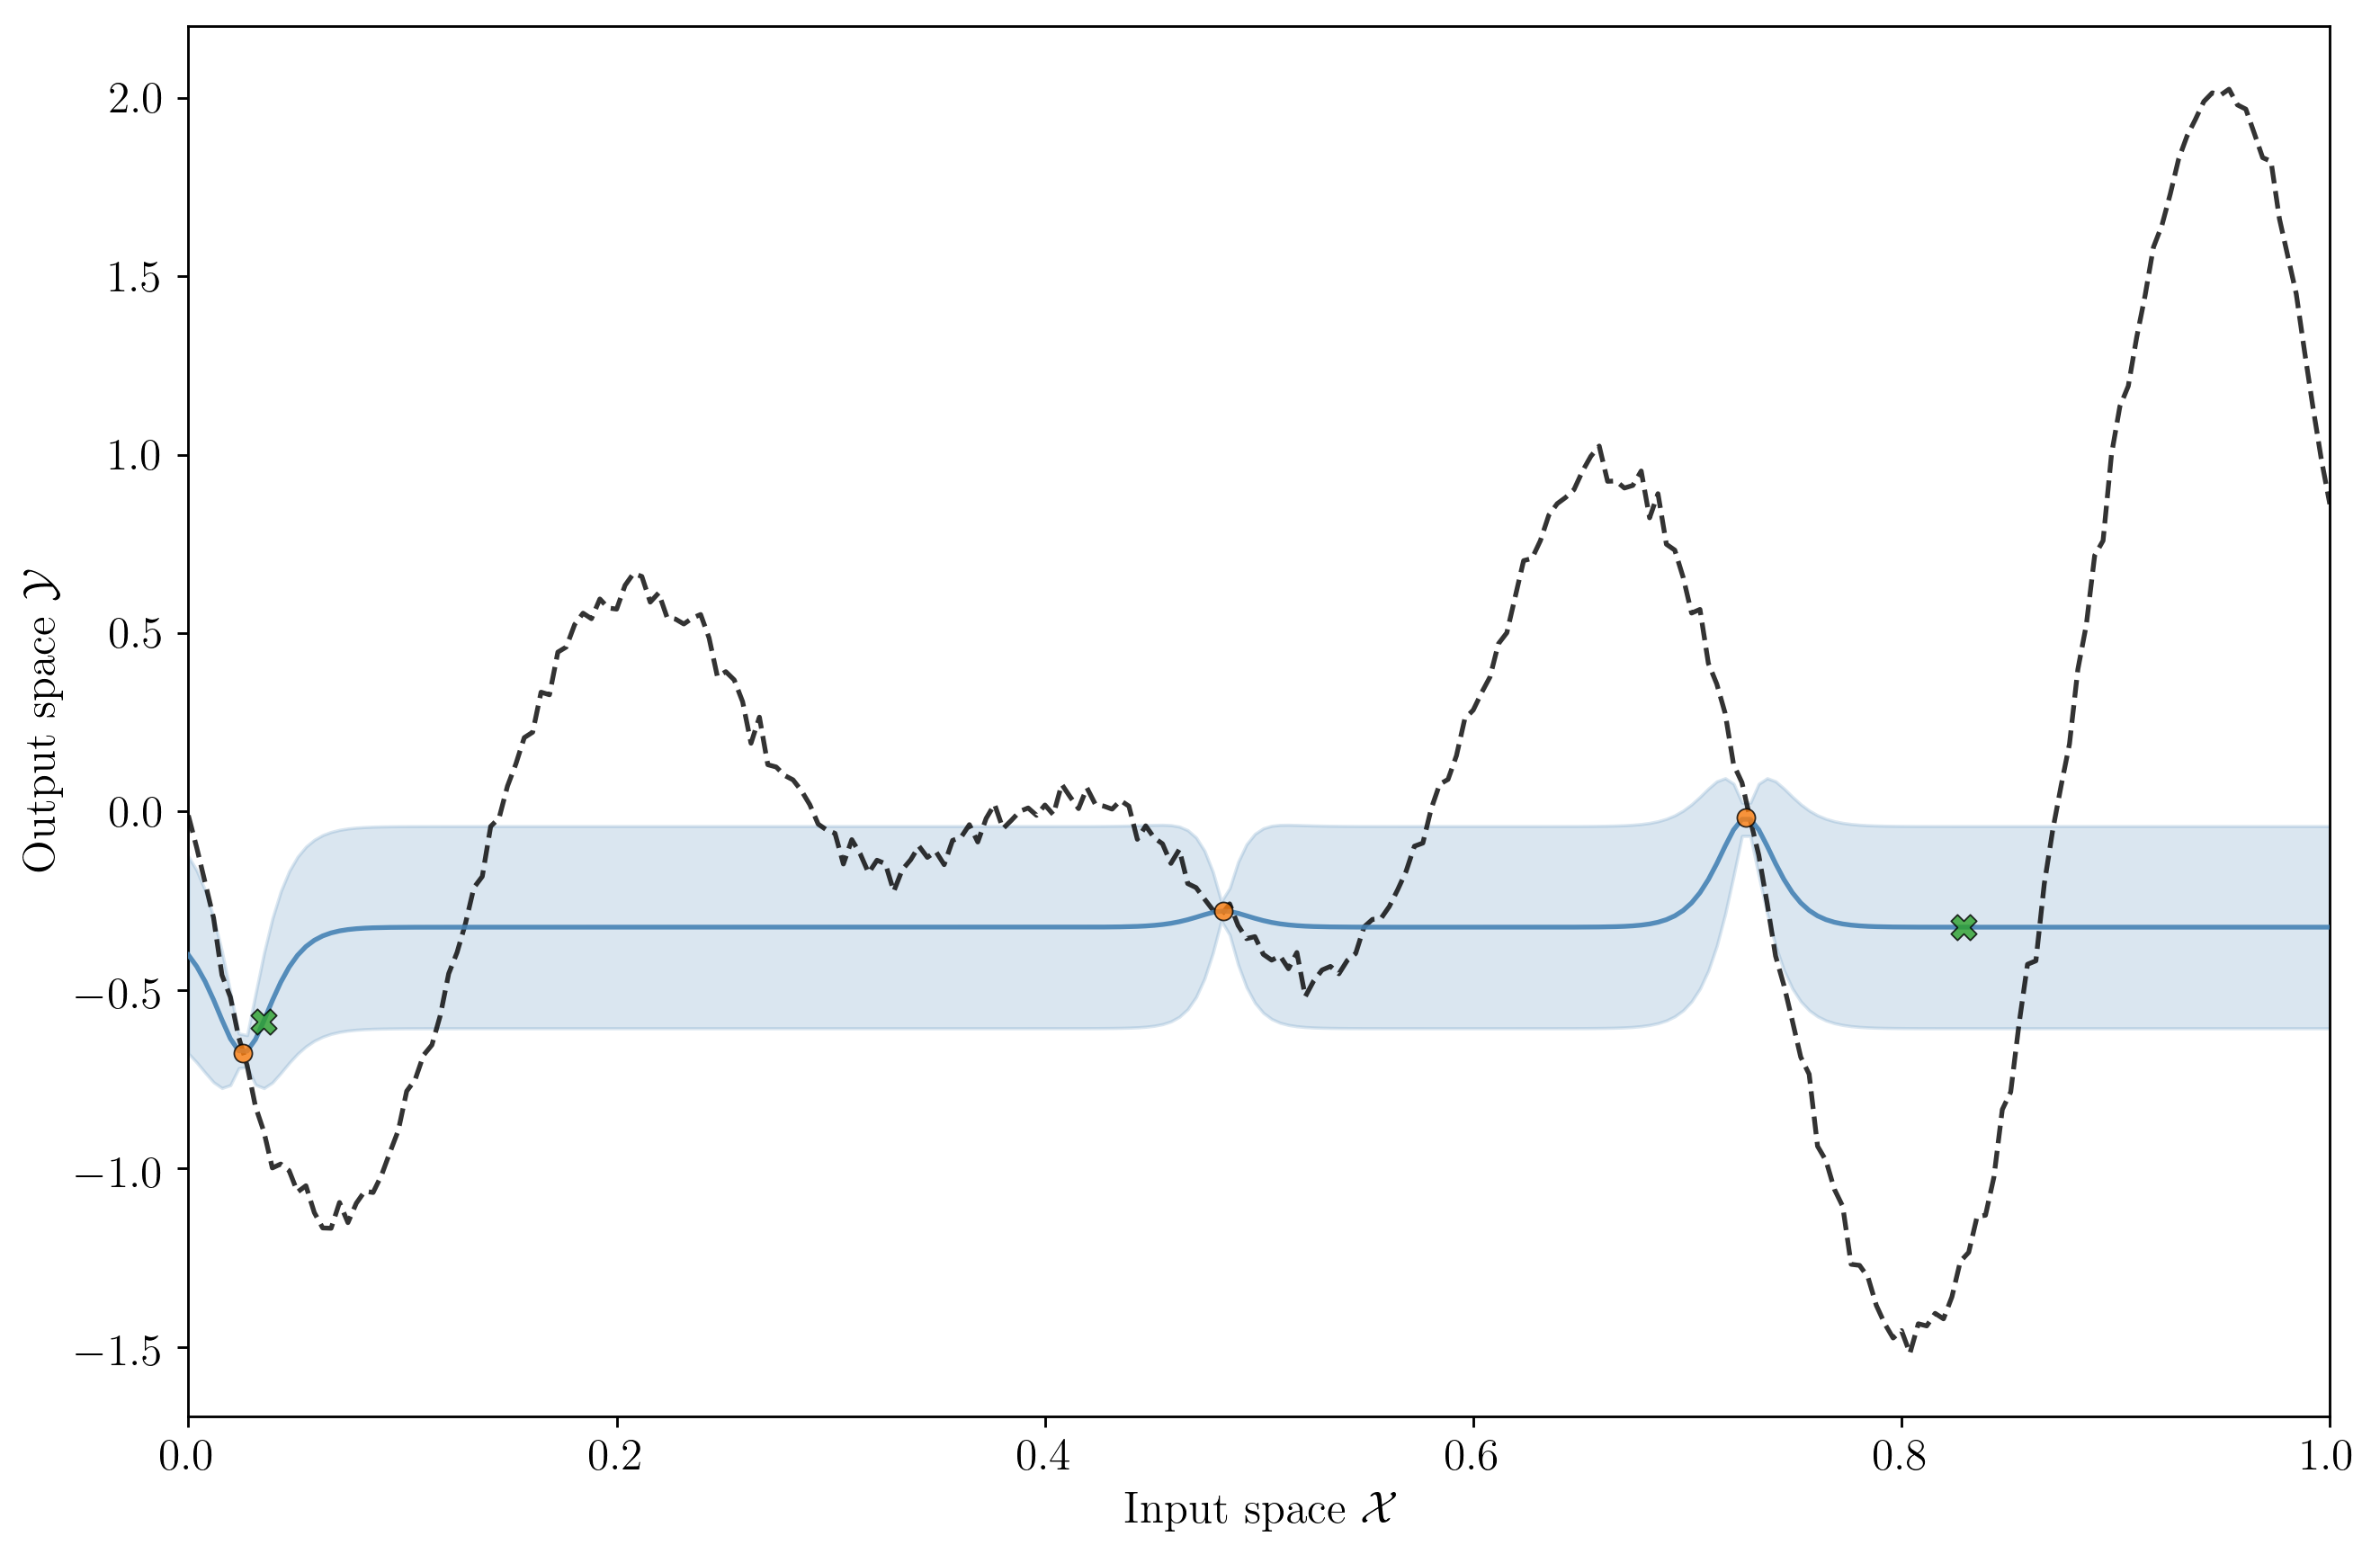

In [15]:
if (task.input_dim == 1):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=14)

    # Run plotter
    ax = plot_posterior(sess, task, model, inputs_old, outputs_old, inputs_new)

    # Add in some bells and whistles
    ax.set_xlim([0, 1])
    ax.set_xlabel('Input space $\mathcal{X}$')
    ax.set_ylabel('Output space $\mathcal{Y}$')
    plt.show()